In [1]:
import pandas as pd
import numpy as np
# виз
from tqdm import tqdm  
from time import sleep 
import matplotlib.pyplot as plt
import seaborn as sns
# стат
from scipy.stats import norm
from scipy import stats
from scipy.stats import chi2_contingency
import statsmodels.stats.power as smp

# воспользуемся кодом из статьи https://habr.com/ru/company/yandex/blog/476826/ 
from bootstrapped import bootstrap as bs
from bootstrapped import stats_functions as bs_st
from scipy.stats import ttest_ind

In [47]:
from IPython.display import HTML

HTML('''
<script src="https://ajax.googleapis.com/ajax/libs/jquery/1.7.1/jquery.min.js" type="text/javascript"></script>
<style>
span{
white-space:normal !important;
}
</style>
<button style="align: center; margin:0 auto; display: block; background-color: #4CAF50;  color: white;  border: 2px solid #4CAF50; /* Green */" onclick="jQuery('.code_cell .input_area').toggle();
    jQuery('.prompt').toggle(); jQuery('.jp-InputArea-editor').toggle(); jQuery('.jp-OutputPrompt').toggle(); jQuery('.jp-InputPrompt').toggle();"><text style = background-color: #4CAF50;>ЧТОБЫ СКРЫТЬ КОД, НАЖМИТЕ СЮДА</text></button>''')

## Здоровье теста

In [46]:
#https://redash.skyeng.ru/queries/32352/source

df = pd.read_csv('data_1.csv') 
df.head()

,test_group,test_group_ab,order_id,application_datetime,geo_group,device_type,utm_group,product_line,orders_win,trans_bernoulli_win,amount_win
0,A1-control,control,14401179,2022-02-21 10:37:50,Регионы РФ,NaN,Edu TM,Математика,NaN,0,NaN
1,B-test,test,14368273,2022-02-17 10:47:51,Регионы РФ,NaN,Edu TM,Математика,NaN,0,NaN
2,B-test,test,13744289,2021-12-03 14:54:04,Регионы РФ,mobile,Partnership,Английский язык для детей,13744289.0,0,NaN
3,B-test,test,13954776,2022-01-03 14:21:28,Регионы РФ,NaN,Mobile App,Математика,13954776.0,0,NaN
4,B-test,test,13895358,2021-12-22 13:38:46,Регионы РФ,NaN,Telemarketing,Английский язык для детей,13895358.0,0,NaN


In [3]:
print("Выборки независимы. Пересечения вариаций исключены из анализа.")

Выборки независимы. Пересечения вариаций исключены из анализа.


In [4]:
# деление по вариациям
df_a0 = df[df.test_group == 'A0-control']
df_a1 = df[df.test_group == 'A1-control']
df_b = df[df.test_group == 'B-test']

In [5]:
# для расчёта С1
с1_a0 = df[df.test_group == 'A0-control'].trans_bernoulli_win
с1_a1 = df[df.test_group == 'A1-control'].trans_bernoulli_win
с1_b = df[df.test_group == 'B-test'].trans_bernoulli_win

### Распределение разницы средних по А/А тесту

In [6]:
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):

    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            len(data_column_1), 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            len(data_column_2), 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1)-statistic(samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.hist(pd_boot_data[0], bins = 50)
    
    plt.style.use('ggplot')
    plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {#"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 572.96it/s]


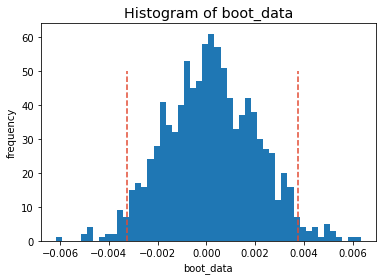

{'ci':               0
 0.025 -0.003245
 0.975  0.003742,
 'p_value': 0.9148167495916354}

In [7]:
get_bootstrap(с1_a0, с1_a1, boot_it = 1000, statistic = np.mean, bootstrap_conf_level = 0.95)

In [8]:
print("Стат.значимой разницы по А/А тесту нет")

Стат.значимой разницы по А/А тесту нет


### Распределение pValue, t статистики и fpr по А/А тесту

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 566.84it/s]


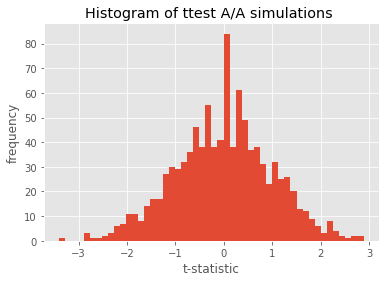

In [9]:
# Распределение t статистики
n = 100000
simulations = 1000
n_s = 1000
res = []

for i in tqdm(range(simulations)):
    s1 = с1_a0.sample(n_s, replace = False).values
    s2 = с1_a1.sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[0]) # сохраняем t-статистику

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('t-statistic')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

In [10]:
print("Распределение t-статистики симметрично")

Распределение t-статистики симметрично


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 571.32it/s]


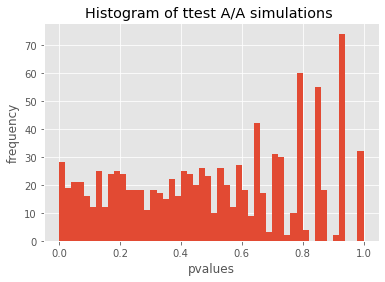

In [11]:
# Распределение pvalue
n = 100000
simulations = 1000
n_s = 1000
res = []

for i in tqdm(range(simulations)):
    s1 = с1_a0.sample(n_s, replace = False).values
    s2 = с1_a1.sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем t-статистику

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

In [12]:
print("Распределение p-value равномерно")

Распределение p-value равномерно


In [13]:
# FPR - Проверяем, что количество ложноположительных случаев не превышает альфа
print("FPR = ",sum(np.array(res) <0.05) / simulations)

FPR =  0.055


### Равномерность разбиения трафика по оригиналу и вариации

In [14]:
df_control = df[df.test_group_ab == 'control']
df_test = df[df.test_group_ab == 'test']

In [15]:
def get_chi(df_control, df_test, column, part=None):
    Control = df_control[column].value_counts()
    Test = df_test[column].value_counts()
    merged = pd.merge(Control, Test, left_index=True, right_index=True)
    merged.columns = ['Control', 'Test']
    # ограничение на использование критерия:
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chi2_contingency.html
    merged_5 = merged[(merged.Control > 5) & (merged.Test > 5)]
    if part:
        print(merged_5.iloc[:part])
        stat, p, dof, expected = chi2_contingency(merged_5.iloc[:part])
    else:
        stat, p, dof, expected = chi2_contingency(merged_5)
    return p

In [16]:
print("Если p-value > 0.05, то нет стат.значимого различия по делению заявок")

Если p-value > 0.05, то нет стат.значимого различия по делению заявок


In [17]:
print("p-value (product_line) = ",get_chi(df_control, df_test, 'product_line'))

p-value (product_line) =  0.5963759501552552


In [18]:
print("p-value (geo_group) = ",get_chi(df_control, df_test, 'geo_group'))

p-value (geo_group) =  0.10336050151744541


In [19]:
print("p-value (device_type) = ",get_chi(df_control, df_test, 'device_type'))

p-value (device_type) =  0.43986855659567325


In [20]:
print("p-value (utm_group) = ",get_chi(df_control, df_test, 'utm_group'))

p-value (utm_group) =  0.2549828789005574


## Воронка С1 с окном 21 день

Основные метрики для рассмотрения: С1, средний чек, ARPU

In [21]:
df_win = df[~df.orders_win.isna()] # таблица только по заявкам с закрытым окном в 21 день

df_win_control = df_win[df_win.test_group_ab == 'control']
df_win_test = df_win[df_win.test_group_ab == 'test']

### Оценка С1 с применением bootstrap

In [28]:
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 10000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_data = []
    nobs=min(len(data_column_1),len(data_column_2)) # чтобы сохранить дисперсию, берем такой же размер выборки
    
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            nobs,
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            nobs, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2

    power = 1 - (min(len([x for x in boot_data if x >= 0]),
        len([x for x in boot_data if x <= 0])) / len(boot_data))
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if abs(bar.get_x()) <= quants.iloc[0][0] or abs(bar.get_x()) >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')

    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0, ymax=50, linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value,
            "power": power}

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:15<00:00, 633.27it/s]


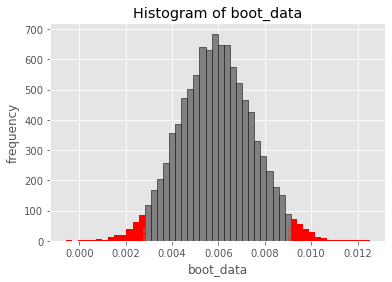

Квантили:               0
0.025  0.002791
0.975  0.009050
power: 0.9999
p_value: 0.0002182495935437178


In [29]:
check = get_bootstrap(df_win_test.trans_bernoulli_win, 
                      df_win_control.trans_bernoulli_win) # в результате хранится разница двух распределений, ДИ и pvalue

print('Квантили:', check['quants'])
print('power:', check['power'])
print('p_value:', check['p_value'])

### Накопительный p-value для С1

In [30]:
data_ab = df_win  # работаем с заявками с закрытым окном
index = []
results = []
for i in range(1000,len(data_ab),500):
    presentDataVar = data_ab.loc[:i,]['test_group_ab'] 
    presentDataValue = data_ab.loc[:i,]['trans_bernoulli_win'] 
    contingency = pd.crosstab(presentDataVar, presentDataValue)
    stat, p_value, dof, ex = chi2_contingency(contingency)  
    index.append(i)
    results.append(p_value)
p_value_open_task_ab = results[-1]


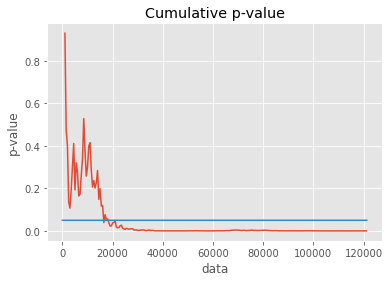

In [31]:
plt.plot(index, results)
plt.plot(np.ones(len(data_ab))*0.05)
plt.xlabel('data')
plt.ylabel('p-value')
plt.title("Cumulative p-value")
plt.show()

### Оценка среднего чека с применением bootstrap

In [32]:
df_check = df[~df.amount_win.isna()] # таблица только по прошедшим оплатам с закрытым окном в 21 день

df_check_control = df_check[df_check.test_group_ab == 'control']
df_check_test = df_check[df_check.test_group_ab == 'test']

100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:03<00:00, 2606.75it/s]


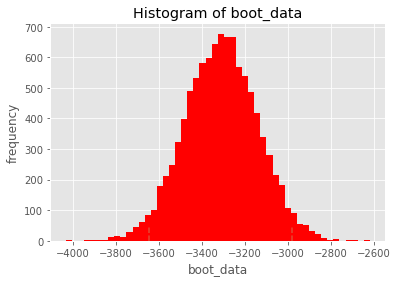

Квантили:                  0
0.025 -3643.447006
0.975 -2979.928668
power: 1.0
p_value: 2.696258788654777e-85


In [33]:
check = get_bootstrap(df_check_test.amount_win, 
                      df_check_control.amount_win) # в результате хранится разница двух распределений, ДИ и pvalue

print('Квантили:', check['quants'])
print('power:', check['power'])
print('p_value:', check['p_value'])

In [34]:
bs_1 = bs.bootstrap(df_check_control.amount_win.values, # переводим в одномерный массив
             stat_func=bs_st.mean, 
             num_iterations=10000, iteration_batch_size=300, 
             return_distribution=True)

bs_2 = bs.bootstrap(df_check_test.amount_win.values,    # переводим в одномерный массив
             stat_func=bs_st.mean, 
             num_iterations=10000, iteration_batch_size=300, 
             return_distribution=True)

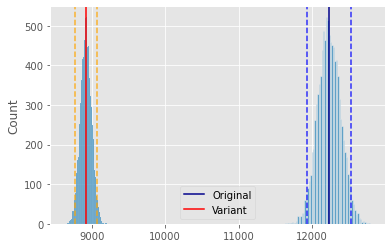

In [35]:
sns.histplot(bs_1)
plt.axvline(bs_1.mean(), color='darkblue', label='Original')
plt.axvline(np.percentile(bs_1, 2.5), color='blue', alpha=.8, linestyle='--')
plt.axvline(np.percentile(bs_1, 97.5), color='blue', alpha=.8, linestyle='--')
sns.histplot(bs_2)
plt.axvline(bs_2.mean(), color='red', label='Variant')
plt.axvline(np.percentile(bs_2, 2.5), color='orange', alpha=.8, linestyle='--')
plt.axvline(np.percentile(bs_2, 97.5), color='orange', alpha=.8, linestyle='--')
plt.legend()

### Оценка ARPU с применением bootstrap

In [38]:
df_arpu = df_win.copy() # таблица только с закрытым окном в 21 день
df_arpu.loc[:,['amount_win']]=df_arpu.amount_win.fillna(0)

df_arpu_control = df_arpu[df_arpu.test_group_ab == 'control']
df_arpu_test = df_arpu[df_arpu.test_group_ab == 'test']

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:17<00:00, 579.89it/s]


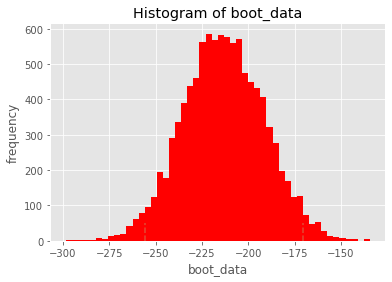

Квантили:                 0
0.025 -256.081342
0.975 -170.675665
power: 1.0
p_value: 1.6609383997004745e-22


In [39]:
check = get_bootstrap(df_arpu_test.amount_win, 
                      df_arpu_control.amount_win) # в результате хранится разница двух распределений, ДИ и pvalue

print('Квантили:', check['quants'])
print('power:', check['power'])
print('p_value:', check['p_value'])

In [40]:
bs_1 = bs.bootstrap(df_arpu_control.amount_win.values, # переводим в одномерный массив
             stat_func=bs_st.mean, 
             num_iterations=10000, iteration_batch_size=300, 
             return_distribution=True)

bs_2 = bs.bootstrap(df_arpu_test.amount_win.values,    # переводим в одномерный массив
             stat_func=bs_st.mean, 
             num_iterations=10000, iteration_batch_size=300, 
             return_distribution=True)

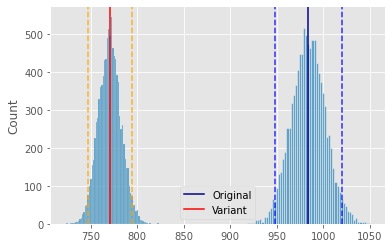

In [41]:
sns.histplot(bs_1)
plt.axvline(bs_1.mean(), color='darkblue', label='Original')
plt.axvline(np.percentile(bs_1, 2.5), color='blue', alpha=.8, linestyle='--')
plt.axvline(np.percentile(bs_1, 97.5), color='blue', alpha=.8, linestyle='--')
sns.histplot(bs_2)
plt.axvline(bs_2.mean(), color='red', label='Variant')
plt.axvline(np.percentile(bs_2, 2.5), color='orange', alpha=.8, linestyle='--')
plt.axvline(np.percentile(bs_2, 97.5), color='orange', alpha=.8, linestyle='--')
plt.legend()